## Imports

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import torch
import torch.nn as nn

import tqdm

from datasets import Dataset

from sklearn.metrics import accuracy_score, precision_score, recall_score

from torch.utils.data import DataLoader

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

## Data preprocessing

In [4]:
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
}

In [5]:
num_partitions = 4

In [6]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [7]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    copied = df[["sentence", "gold_label"]].rename(columns={"sentence": "text", "gold_label": "label"})
    copied = copied[copied.label != "mixed"].dropna()
    copied["label"] = copied["label"].map(label_mapping)

    return copied

In [8]:
def tokenize_data(ds: Dataset, tokenizer: PreTrainedTokenizer) -> pd.DataFrame:
    copied = ds.map(
        lambda s, tok: {
            "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
            "attention_mask": encoded["attention_mask"],
        },
        fn_kwargs={"tok": tokenizer},
    )

    return copied

In [9]:
training_data = [pd.read_json(f"data/partitions/iid_partition_{i}.jsonl", lines=True) for i in range(num_partitions)]
validation_data = pd.concat([
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-test.jsonl", lines=True)),
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-dev.jsonl", lines=True)),
], ignore_index=True).drop_duplicates()

In [10]:
training_ds = [tokenize_data(Dataset.from_pandas(df, preserve_index=False), distilbert_tokenizer) for df in training_data]
validation_ds = tokenize_data(Dataset.from_pandas(validation_data, preserve_index=False), distilbert_tokenizer)

Map:   0%|          | 0/11950 [00:00<?, ? examples/s]

Map:   0%|          | 0/11950 [00:00<?, ? examples/s]

Map:   0%|          | 0/11950 [00:00<?, ? examples/s]

Map:   0%|          | 0/11950 [00:00<?, ? examples/s]

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

In [11]:
training_ds = [ds.with_format(type="torch", columns=["ids", "label", "attention_mask"]) for ds in training_ds]
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [12]:
def get_data_loader(dataset: Dataset, batch_size: int, pad_index, shuffle=False) -> DataLoader:
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        batch_label = torch.stack([i["label"] for i in batch])
        batch_mask = nn.utils.rnn.pad_sequence([i["attention_mask"] for i in batch], padding_value=pad_index, batch_first=True)
        
        return {
            "ids": batch_ids,
            "label": batch_label,
            "attention_mask": batch_mask,
        }
    
    dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

In [13]:
training_dl = [get_data_loader(ds, 32, distilbert_tokenizer.pad_token_id, shuffle=True) for ds in training_ds]
validation_dl = get_data_loader(validation_ds, 32, distilbert_tokenizer.pad_token_id)

## Model definition

In [14]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes: int, freeze: bool):
        super().__init__()
        
        self.transformer = transformer
        self.fc = nn.Linear(transformer.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    
    def forward(self, ids: torch.Tensor, attention_mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        output = self.transformer(ids, attention_mask=attention_mask, output_attentions=True)
        pooled_mean = torch.mean(output.last_hidden_state, dim=1)
        cls_hidden = self.dropout(pooled_mean)
        prediction = self.fc(cls_hidden)

        return prediction, output.attentions

In [15]:
distilbert_tf = AutoModel.from_pretrained("distilbert-base-uncased", attn_implementation="eager")

model = Transformer(distilbert_tf, num_classes=3, freeze=False)

## Loading from backup
### Checkpoint loading

In [16]:
r = 8

In [ ]:
initial_state_dict = model.state_dict()

In [ ]:
checkpoint = torch.load(f"model/iid/fedavg_r{r - 1}.pth")

In [ ]:
initial_state_dict = checkpoint["model_state_dict"]

In [ ]:
model.load_state_dict(initial_state_dict)

## Model configuration

In [ ]:
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print(model)

## Training (preparation)

In [ ]:
def get_accuracy(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return accuracy_score(actual_labels, predicted_classes)

def get_precision(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return precision_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def get_recall(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return recall_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def get_f1_score(precision: np.float64, recall: np.float64) -> np.float64:
    return np.float64(2.0) * (precision * recall) / (precision + recall)

In [ ]:
def train(
        net: Transformer,
        data_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
) -> tuple[np.float64, np.float64, np.float64, np.float64, np.float64]:
    net.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        prediction, _ = net(ids, attention_mask)
        
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        recall = get_recall(prediction, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
        batch_precisions.append(precision)
        batch_recalls.append(recall)

    avg_loss = np.mean(batch_losses)
    avg_accuracy = np.mean(batch_accuracies)
    avg_precision = np.mean(batch_precisions)
    avg_recall = np.mean(batch_recalls)
    f1_score = get_f1_score(avg_precision, avg_recall)
        
    return avg_loss, avg_accuracy, avg_precision, avg_recall, f1_score


def run_local(
        net: Transformer,
        training_loaders: list[DataLoader],
        fl_round: int,
        learning_rate: float,
        client: int,
):
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []
    
    optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
        
    train_loss, train_accuracy, train_precision, train_recall, train_f1_score = train(net, training_loaders[client], optimizer)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1_score)

    print(f"{train_loss = }")
    print(f"{train_accuracy = }")
    print(f"{train_precision = }")
    print(f"{train_recall = }")
    print(f"{train_f1_score = }")
    
    torch.save({
        "round": fl_round,
        "model_state_dict": net.state_dict(),
        "train": {
            "loss": train_loss,
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1_score,
        },
    }, f"model/iid/partition_c{client}_r{fl_round}.pth")


def eval_centralized(net: Transformer, data_loader: DataLoader) -> dict[str, np.float64]:
    net.eval()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            prediction, _ = net(ids, attention_mask)
            
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            recall = get_recall(prediction, label)
            
            batch_losses.append(loss.item())
            batch_accuracies.append(accuracy)
            batch_precisions.append(precision)
            batch_recalls.append(recall)

    avg_loss = np.mean(batch_losses)
    avg_accuracy = np.mean(batch_accuracies)
    avg_precision = np.mean(batch_precisions)
    avg_recall = np.mean(batch_recalls)
    f1_score = get_f1_score(avg_precision, avg_recall)

    print(f"{avg_loss = }")
    print(f"{avg_accuracy = }")
    print(f"{avg_precision = }")
    print(f"{avg_recall = }")
    print(f"{f1_score = }")

    metrics = {
        "loss": avg_loss,
        "accuracy": avg_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1_score": f1_score,
    }

    return metrics

In [ ]:
lr = 1e-6

## Training

In [ ]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=0)

In [ ]:
model.load_state_dict(initial_state_dict)

In [ ]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=1)

In [ ]:
model.load_state_dict(initial_state_dict)

In [ ]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=2)

In [ ]:
model.load_state_dict(initial_state_dict)

In [ ]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=3)

In [ ]:
model.load_state_dict(initial_state_dict)

### Model saving

In [ ]:
def fed_avg(global_model, model_state_dicts):
    ds_lengths = [len(ds) for ds in training_ds]
    total_samples = sum(ds_lengths)
    weights = [l / total_samples for l in ds_lengths]
    
    global_dict = global_model.state_dict()
    
    for k in global_dict.keys():
        global_dict[k] = torch.zeros_like(global_dict[k])
        
        for i in range(len(model_state_dicts)):
            global_dict[k] += model_state_dicts[i][k] * weights[i]
            
    global_model.load_state_dict(global_dict)
    
    return global_model

In [ ]:
local_state_dicts = [torch.load(f"model/iid/partition_c{i}_r{r}.pth")["model_state_dict"] for i in range(num_partitions)]
model = fed_avg(model, local_state_dicts)

In [ ]:
eval_metrics = eval_centralized(model, validation_dl)

In [ ]:
torch.save({
    "round": r,
    "model_state_dict": model.state_dict(),
    "test": eval_metrics,
}, f"model/iid/fedavg_r{r}.pth")

### Evaluation Results

In [19]:
client_losses = {i: [] for i in range(r)}
server_losses = []

In [20]:
client_accuracies = {i: [] for i in range(r)}
server_accuracies = []

In [21]:
client_f1_scores = {i: [] for i in range(r)}
server_f1_scores = []

In [ ]:
pth_files = [f for f in os.listdir("model/iid") if f.endswith(".pth")]

In [ ]:
for pth in pth_files:
    pth_data = torch.load(f"model/iid/{pth}")
    del pth_data["model_state_dict"]

    if "train" in pth_data:
        for metric in pth_data["train"]:
            pth_data["train"][metric] = pth_data["train"][metric][0]

    with open(f"model/iid/iid_{pth.removesuffix('.pth')}.json", "w", encoding="utf-8") as json_file:
        json.dump(pth_data, json_file, indent=4)

In [22]:
for fl_round in range(r):
    print(f"##### Round {fl_round} #####")

    for client in range(num_partitions):
        print(f"--- Client {client} ---")

        with open(f"model/iid/iid_partition_c{client}_r{fl_round}.json") as json_data:
            train_metrics = json.load(json_data)["train"]

            client_losses[client].append(train_metrics["loss"])
            client_accuracies[client].append(train_metrics["accuracy"])
            client_f1_scores[client].append(train_metrics["f1_score"])

            for metric in train_metrics:
                print(f"{metric} = {train_metrics[metric]}")

    print("--- Aggregated model ---")

    with open(f"model/iid/iid_fedavg_r{fl_round}.json") as json_data:
        test_metrics = json.load(json_data)["test"]

        server_losses.append(test_metrics["loss"])
        server_accuracies.append(test_metrics["accuracy"])
        server_f1_scores.append(test_metrics["f1_score"])

        for metric in test_metrics:
            print(f"{metric} = {test_metrics[metric]}")

##### Round 0 #####
--- Client 0 ---
loss = 0.9753667600652113
accuracy = 0.5368482620320856
precision = 0.25607522999920673
recall = 0.3408803800695168
f1_score = 0.2924539790101622
--- Client 1 ---
loss = 0.961005668589138
accuracy = 0.5673343200916731
precision = 0.20317257767849659
recall = 0.33347929749075844
f1_score = 0.25250577370010174
--- Client 2 ---
loss = 0.9769412049635209
accuracy = 0.5518764323911383
precision = 0.1912814667012061
recall = 0.3332807958505381
f1_score = 0.24306147813043513
--- Client 3 ---
loss = 0.9716639655796602
accuracy = 0.5607095110771582
precision = 0.19408037322011729
recall = 0.3327304859084225
f1_score = 0.24515993080947943
--- Aggregated model ---
loss = 1.0993475868966844
accuracy = 0.33305555555555555
precision = 0.11104838709677418
recall = 0.333042328042328
f1_score = 0.16655972351266513
##### Round 1 #####
--- Client 0 ---
loss = 0.9457256628230294
accuracy = 0.5539295263559969
precision = 0.19257292359759154
recall = 0.33437984079695315


In [23]:
epoch_rng = range(1, r + 1)

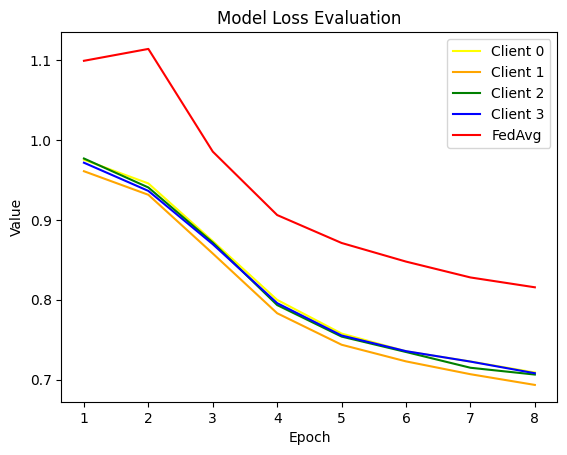

In [26]:
plt.plot(epoch_rng, client_losses[0], label="Client 0", color="yellow")
plt.plot(epoch_rng, client_losses[1], label="Client 1", color="orange")
plt.plot(epoch_rng, client_losses[2], label="Client 2", color="green")
plt.plot(epoch_rng, client_losses[3], label="Client 3", color="blue")
plt.plot(epoch_rng, server_losses, label="FedAvg", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Loss Evaluation")
plt.legend()
plt.show()

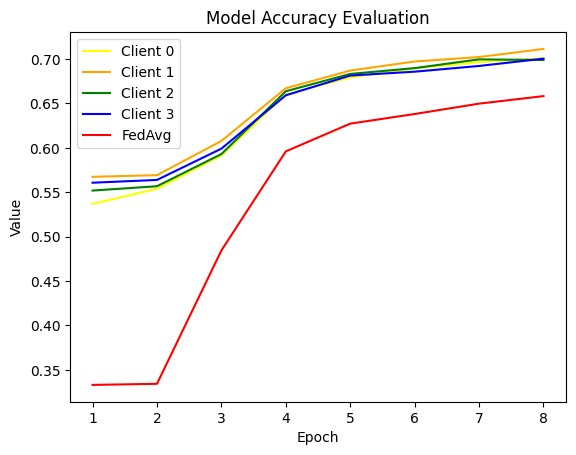

In [27]:
plt.plot(epoch_rng, client_accuracies[0], label="Client 0", color="yellow")
plt.plot(epoch_rng, client_accuracies[1], label="Client 1", color="orange")
plt.plot(epoch_rng, client_accuracies[2], label="Client 2", color="green")
plt.plot(epoch_rng, client_accuracies[3], label="Client 3", color="blue")
plt.plot(epoch_rng, server_accuracies, label="FedAvg", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Accuracy Evaluation")
plt.legend()
plt.show()

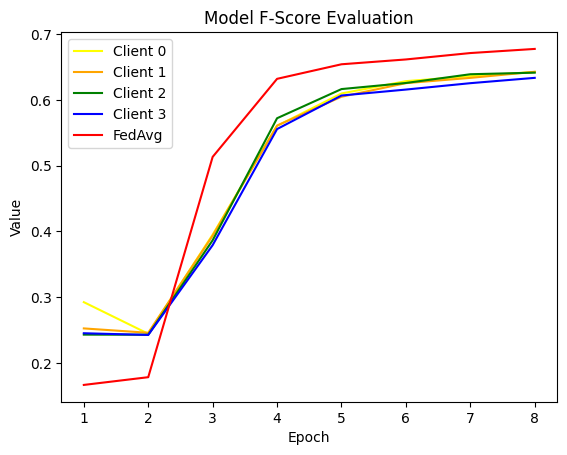

In [28]:
plt.plot(epoch_rng, client_f1_scores[0], label="Client 0", color="yellow")
plt.plot(epoch_rng, client_f1_scores[1], label="Client 1", color="orange")
plt.plot(epoch_rng, client_f1_scores[2], label="Client 2", color="green")
plt.plot(epoch_rng, client_f1_scores[3], label="Client 3", color="blue")
plt.plot(epoch_rng, server_f1_scores, label="FedAvg", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model F-Score Evaluation")
plt.legend()
plt.show()